
# EfficientNetB3 Model

In [ ]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#google colab mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import glob as gb
import cv2
import tensorflow as tf
import os


from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, Lambda, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#For image preprocessing
from  tensorflow.keras import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#for google colab, primary computer
augmented_images_path = '/content/drive/MyDrive/DSI30/Capstone/Datasets/onemonkeypoxskinlesion/Augmented Images'
test_path = '/content/drive/MyDrive/DSI30/Capstone/Datasets/onemonkeypoxskinlesion/Fold1/Test'
train_path = '/content/drive/MyDrive/DSI30/Capstone/Datasets/onemonkeypoxskinlesion/Fold1/Train'
val_path = '/content/drive/MyDrive/DSI30/Capstone/Datasets/onemonkeypoxskinlesion/Fold1/Val'
original_image_path= '/content/drive/MyDrive/DSI30/Capstone/Datasets/onemonkeypoxskinlesion/Original Images'

In [ ]:
training1_set = preprocessing.image_dataset_from_directory(directory=train_path,
                                                 image_size = (224, 224),
                                                 batch_size = 32,
                                                 label_mode="binary")
test1_set = preprocessing.image_dataset_from_directory(directory=test_path,
                                            image_size = (224, 224),
                                            batch_size = 32,
                                            label_mode="binary",
                                            shuffle=False)
val1_set = preprocessing.image_dataset_from_directory(directory=val_path,
                                            image_size = (224, 224),
                                            batch_size = 32,
                                            label_mode="binary",
                                            shuffle=False)

Found 2142 files belonging to 2 classes.
Found 45 files belonging to 2 classes.
Found 420 files belonging to 2 classes.


## Model

In [ ]:
#EfficientNetB3 base model

base_model = EfficientNetB3(include_top=False)
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False


inputs = Input(shape=(224, 224, 3), name="input_layer")
base_layer = base_model(inputs)
dropout_layer_1 = Dropout(0.5)(base_layer)
flat_layer = GlobalAveragePooling2D()(dropout_layer_1)
dense_1 = Dense(256, activation="relu")(flat_layer)
dropout_layer_2 = Dropout(0.5)(dense_1)
dense_2 = Dense(128, activation="relu")(dropout_layer_2)
outputs = Dense(1, activation="sigmoid")(dense_2)
model = Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, None, None, 1536)  10783535 
                                                                 
 dropout (Dropout)           (None, 7, 7, 1536)        0         
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                             

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [ ]:
#Early stopping to avoid overfitting of model
#patience is the number of epochs without improvement after which training will be early stopped
# checkpoint and early stopping
filepath="/content/drive/MyDrive/DSI30/Capstone/efficientnetb3weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy',mode='max', patience=20)
callbacks_list = [checkpoint, es]

In [ ]:
# fit the model
history = model.fit(
  training1_set,
  validation_data=(val1_set),
  epochs=100,
  callbacks=[callbacks_list],
  batch_size=32,shuffle=True)

Epoch 1/100
67/67 [==============================] - ETA: 0s - loss: 0.3220 - accuracy: 0.8581
Epoch 1: val_accuracy improved from -inf to 0.77381, saving model to /content/drive/MyDrive/DSI30/Capstone/efficientnetb3weights.hdf5
67/67 [==============================] - 35s 231ms/step - loss: 0.3220 - accuracy: 0.8581 - val_loss: 0.5369 - val_accuracy: 0.7738
Epoch 2/100
67/67 [==============================] - ETA: 0s - loss: 0.1439 - accuracy: 0.9444
Epoch 2: val_accuracy improved from 0.77381 to 0.78810, saving model to /content/drive/MyDrive/DSI30/Capstone/efficientnetb3weights.hdf5
67/67 [==============================] - 12s 177ms/step - loss: 0.1439 - accuracy: 0.9444 - val_loss: 0.5514 - val_accuracy: 0.7881
Epoch 3/100
67/67 [==============================] - ETA: 0s - loss: 0.1057 - accuracy: 0.9580
Epoch 3: val_accuracy improved from 0.78810 to 0.82857, saving model to /content/drive/MyDrive/DSI30/Capstone/efficientnetb3weights.hdf5
67/67 [==============================] - 12

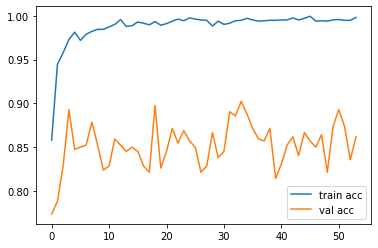

In [ ]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

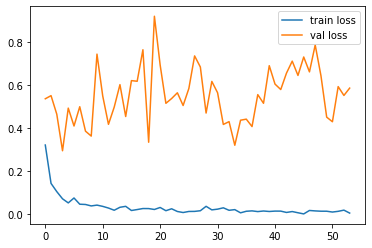

In [ ]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

## Predict

In [ ]:
model.load_weights("/content/drive/MyDrive/DSI30/Capstone/efficientnetb3weights.hdf5")

In [ ]:
#model evaultion
model.evaluate(test1_set,batch_size=32)

2/2 [==============================] - 1s 767ms/step - loss: 0.3836 - accuracy: 0.8889


[0.38364240527153015, 0.8888888955116272]

In [ ]:
y_pred = tf.math.round(model.predict(test1_set))
y_true = []
for images, labels in test1_set.unbatch():
  y_true.append(labels.numpy())

In [ ]:
accuracy_score(y_true, y_pred)

0.8888888888888888

In [ ]:
print(classification_report(y_true, y_pred, target_names=training1_set.class_names))

              precision    recall  f1-score   support

   Monkeypox       0.80      1.00      0.89        20
      Others       1.00      0.80      0.89        25

    accuracy                           0.89        45
   macro avg       0.90      0.90      0.89        45
weighted avg       0.91      0.89      0.89        45



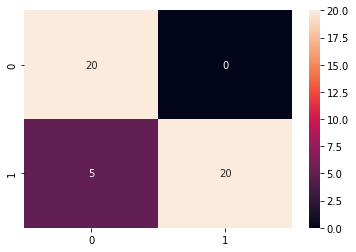

In [ ]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm.astype("int"), annot=True);

In [ ]:
#primary account/computer

df = []


#for folder in  os.listdir(test_path) : 
files = gb.glob(pathname= str(test_path +'/' + 'Monkeypox' + '/*.jpg'))
for file in files:
  imagesplit = file.split('/')
  imagename = [imagesplit[11], imagesplit[10]]
  df.append(imagename)

files = gb.glob(pathname= str(test_path +'/' + 'Others' + '/*.jpg'))
for file in files:
  imagesplit = file.split('/')
  imagename = [imagesplit[11], imagesplit[10]]
  df.append(imagename)

df2 =[]
for pred in y_pred:
      pred = str(pred)
      filter = (pred.split('.'))[1]
      filter2 = (filter.split('['))[1]
      df2.append(filter2)

df = pd.DataFrame (df, columns = ['file_name', 'class'])

df['pred']= df2
df

,file_name,class,pred
0,M19_01.jpg,Monkeypox,0
1,M04_01.jpg,Monkeypox,0
2,M43_02.jpg,Monkeypox,0
3,M48_01.jpg,Monkeypox,0
4,M40_03.jpg,Monkeypox,0
5,M43_01.jpg,Monkeypox,0
6,M39_02.jpg,Monkeypox,0
7,M38_02.jpg,Monkeypox,0
8,M45_01.jpg,Monkeypox,0
9,M38_01.jpg,Monkeypox,0


In [ ]:
model.save("efficientnetb3_model")

In [ ]:
#creating dataframe for monkeypox and others
df_monkeypox = df.loc[df['class'] == 'Monkeypox']
df_others = df.loc[df['class'] == 'Others']

#misclassified df
df_monkeypox_false_negative = df_monkeypox.loc[df['pred'] == '1']
df_monkeypox_false_positive = df_others.loc[df['pred'] == '0']

In [ ]:
df_monkeypox_false_negative

,file_name,class,pred


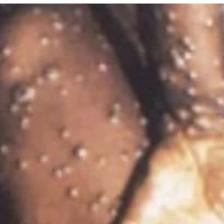

In [ ]:
#false negative
image = tf.keras.utils.load_img(f'/content/drive/MyDrive/DSI30/Capstone/Datasets/onemonkeypoxskinlesion/Fold1/Test/Monkeypox/M40_01.jpg', target_size = (224, 224))

image

In [ ]:
df_monkeypox_false_positive

,file_name,class,pred
20,NM52_01.jpg,Others,0
31,NM54_01.jpg,Others,0
35,NM41_01.jpg,Others,0
37,NM67_01.jpg,Others,0
40,NM79_01.jpg,Others,0


In [ ]:
#false positive
image1=tf.keras.utils.load_img(f'/content/drive/MyDrive/DSI30/Capstone/Datasets/onemonkeypoxskinlesion/Fold1/Test/Others/NM52_01.jpg', target_size = (224, 224))
image2= tf.keras.utils.load_img(f'/content/drive/MyDrive/DSI30/Capstone/Datasets/onemonkeypoxskinlesion/Fold1/Test/Others/NM54_01.jpg', target_size = (224, 224))
image3 =tf.keras.utils.load_img(f'/content/drive/MyDrive/DSI30/Capstone/Datasets/onemonkeypoxskinlesion/Fold1/Test/Others/NM41_01.jpg', target_size = (224, 224))
image4 =tf.keras.utils.load_img(f'/content/drive/MyDrive/DSI30/Capstone/Datasets/onemonkeypoxskinlesion/Fold1/Test/Others/NM67_01.jpg', target_size = (224, 224))
image5 = tf.keras.utils.load_img(f'/content/drive/MyDrive/DSI30/Capstone/Datasets/onemonkeypoxskinlesion/Fold1/Test/Others/NM79_01.jpg', target_size = (224, 224))

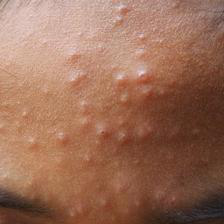

In [ ]:
image1

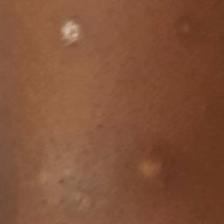

In [ ]:
image2

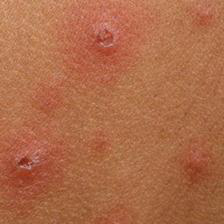

In [ ]:
image3

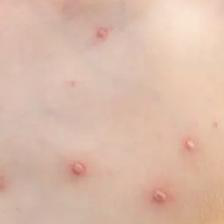

In [ ]:
image4

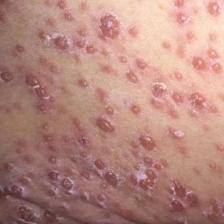

In [ ]:
image5